## Package Installation

In [ ]:

!pip install alpaca_trade_api
!pip install polygon-api-client

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from polygon import RESTClient
from datetime import datetime  
from datetime import timedelta
import sys
import websocket, json
import math
import pytz
import datetime

## Alpaka.market API Credentials
It uses papertrading as base url, change this url when working with live trading. API and SECRET_KEYS are separated
1.   Mamun
2.   Premius
3.   Tanjeel






In [ ]:
MAMUN_API_KEY = "PKDIGV6H0R5GC1LVHFMY"
MAMUN_SECRET_KEY = "vJdOZFH9x7IezS0TX3fqTvAlFaiOaLRXvCooKHFF"

PREMIUS_API_KEY='PK5616ETLC9V7KJ9J4Q5'
PREMIUS_SECRET_KEY='Uz8UtHjPRw6x71whpJgHgYPRHqxAjlcmML2MPmRb'

TANJEEL_API_KEY = ""
TANJEEL_SECRET_KEY = ""

BASE_URL='https://paper-api.alpaca.markets'

Create API with creadentials

In [ ]:
alpaka_api=tradeapi.REST(
    PREMIUS_API_KEY,
    PREMIUS_SECRET_KEY,
    BASE_URL    
)

## Alpaka.market API Handler Functions

In [ ]:
def get_alpaka_account_info():
  """
  collect account info from aplapaka authorized API
  """
  return alpaka_api.get_account()

In [ ]:
def get_symbol_asset(symbol):
  """
  get asset of a given symbol from alpaka api and returns the asset object
  :param symbol: uppercased valid ticker symbol for alpaka
  """
  return alpaka_api.get_asset(symbol)

In [ ]:
def get_company_name(symbol_asset):
  """
  get company name from symbol_asset
  :param symbol_asset: returned value of get_symbol_asset function
  """
  return symbol_asset.name

In [ ]:
def get_shortable_status(symbol_asset):
  """
  get shortable status from the symbol_asset.
  :param symbol_asset: returned value of get_symbol_asset function
  :returns: 'S' - shortable, else 'N' - non shortable
  """
  if symbol_asset.shortable:
    return 'S'
  else:
    return 'N'
  

Order Placing Functions

In [ ]:
def buy_order(order_type,symbol,quantity,**kwargs):
    """
    Buy some given quantity of given symbol based on given order_type
    Currentyly supports three order_type - limit,market,stop_limit 
    :param order_type: str - allowed types are limit, stop limit, market
    :param symbol: str - ticker symbol that you want to buy
    :param quantity: str - integer quantity as string. The quantity you want to buy
    :param kwargs: used for other important parameter. For exmaple limit_price when the order type is limit, limit_price and stop_price when the order is stop_limit
    :returns: Order Object
    """
    if order_type=='market':
      return alpaka_api.submit_order(
          symbol=symbol,
          qty=quantity,
          side='buy',
          type=order_type,
          time_in_force='gtc'
      )
    elif order_type=='limit':
      limit_price=float(kwargs["limit_price"])
      return alpaka_api.submit_order(
          symbol=symbol,
          qty=quantity,
          side='buy',
          type=order_type,
          time_in_force='opg',
          limit_price=limit_price
      )
    elif order_type=="stop_limit":
      limit_price=float(kwargs["limit_price"])
      stop_price=float(kwargs["stop_price"])
      return alpaka_api.submit_order(
          symbol=symbol,
          qty=quantity,
          side='buy',
          type=order_type,
          time_in_force='opg',
          limit_price=limit_price,
          stop_price=stop_price
      )


In [ ]:
def sell_order(order_type,symbol,quantity,**kwargs):
    """
    Sell some given quantity of given symbol based on given order_type
    Currentyly supports three order_type - limit,market,stop_limit
    :param order_type: str - allowed types are limit, stop_limit, market
    :param symbol: str - ticker symbol that you want to sell
    :param quantity: str - integer quantity as string. The quantity you want to sell
    :param kwargs: used for other important parameter. For exmaple limiting_price when the order type is limit
    :returns: Order Object
    """

    if order_type=='market':
      return alpaka_api.submit_order(
          symbol=symbol,
          qty=quantity,
          side='sell',
          type=order_type,
          time_in_force='gtc'
      )
    elif order_type=='limit':
      limit_price=float(kwargs["limit_price"])
      return alpaka_api.submit_order(
          symbol=symbol,
          qty=quantity,
          side='sell',
          type=order_type,
          time_in_force='opg',
          limit_price=limit_price
      )
    elif order_type=="stop_limit":
      limit_price=float(kwargs["limit_price"])
      stop_price=float(kwargs["stop_price"])
      return alpaka_api.submit_order(
          symbol=symbol,
          qty=quantity,
          side='sell',
          type=order_type,
          time_in_force='opg',
          limit_price=limit_price,
          stop_price=stop_price
      )

## UNIX NANO Timestamp Handler Functions

In [ ]:
def get_current_unix_time():
  """
  Modify this function and make it to return current timestamp in nanosecond.
  This function must support dynamic time zone
  :returns current_unix_nano: timestamp of current time zone where time zone is custom
  """
  current_unix_mili = 1620996840000
  current_unix_nano = current_unix_mili * 1000000 
  return current_unix_nano

In [ ]:
def get_n_min_prev_unix(nano_unix,n):
  """
  Reduce n minutes from given nano_unix and return the calculated nano_unix
  :param nano_unix: the base timestamp in nano second
  :param n: number of minutes that needs to be reduced from nano_unix
  :returns: n minutes previous timestamp based on nano_unix param
  """
  return nano_unix - (n*60000000000)

In [ ]:
def get_n_min_next_unix(nano_unix,n):
  """
  Add n minutes with given nano_unix and return the calculated nano_unix
  :param nano_unix: the base timestamp in nano second
  :param n: number of minutes that needs to be added with nano_unix
  :returns: n minutes next timestamp based on nano_unix param
  """
  return nano_unix + (n*60000000000)

## Polygon.io credentials

In [ ]:
polygon_auth_key = "Zay2cQZwZfUTozLiLmyprY4Sr3uK27Vp"

## Polygon.io API Handler Functions

In [ ]:
def get_last_30_min_data(polygon_auth_key,symbol,target_iso_date = "2021-05-14"):
  """
  Collect last 30 minutes of trade data from polygon.io using restapi.
  Current time is considered as nano_unix timestamp.
  This function uses custom paging mechanism to get data from polygon
  if data is not available then returns None
  :param polygon_auth_key: auth key of polygon api
  :param symbol: ticker symbol which data need to be scraped
  :param target_iso_date: Iso format of a date only which will be checked for data scraping
  :returns: pd.DataFrame()["time","column"] or None
  """
  df = pd.DataFrame()
  current_stamp = get_current_unix_time()
  recent_stamp = get_n_min_prev_unix(current_stamp,30)
  with RESTClient(polygon_auth_key) as client:
    prices = []
    time_unixs = []
    collecting = True
    while collecting:
      resp = client.historic_trades_v2(symbol, target_iso_date, timestamp=recent_stamp, timestampLimit=current_stamp)
      for i in resp.results:
        prices.append(i['p'])
        time_unixs.append(i['y'])
        
      try:
        if recent_stamp == time_unixs[(len(time_unixs) - 1)]:
          collecting=False
        else:
          recent_stamp = time_unixs[(len(time_unixs) - 1)]
      except IndexError:
        print("Last 30 min data is not available")
        return None

    df["price"] = prices
    df["time"] = time_unixs
    return df

In [ ]:
def get_30_min_res_with_quantity_formula(df):
  """
  1. Seperates 30 mins of data into three separate 10 mins dataframe
  2. Calculate average of three different dataframes
  3. Apply quantity formula
  :param: df : dataframe returned from get_last_30_min_data function. Format: pd.DataFrame()["time","column"] or None
  :returns: int by flooring the calculated value
  """
  if (df is None) or len(df)<3:
    return 0
  else:
    first_10_min = df.loc[df["time"]<=(get_n_min_next_unix(df["time"][0],10))]
    second_10_min = df.loc[(df["time"]>get_n_min_next_unix(df["time"][0],10)) & (df["time"]<=get_n_min_next_unix(df["time"][0],20))]
    third_10_min = df.loc[df["time"]>(get_n_min_next_unix(df["time"][0],20))]

    A=sum(first_10_min['price'])/len(first_10_min['price'])
    B=sum(second_10_min['price'])/len(second_10_min['price'])
    C=sum(third_10_min['price'])/len(third_10_min['price'])
    return math.floor(((A*3)+(B*2)+C)/120)

## Code Checkup

In [ ]:
# Code Checkup Company name
symbol=input("Enter the ticker symbol of Desired Company\n").upper()
asset = get_symbol_asset(symbol)
get_company_name(asset)

Enter the ticker symbol of Desired Company
AAPL


'Apple Inc. Common Stock'

In [ ]:
# Code checkup Quantity Calculation
df_30_min = get_last_30_min_data(polygon_auth_key=polygon_auth_key, symbol=symbol, target_iso_date="2021-05-14")
quantity = get_30_min_res_with_quantity_formula(df_30_min)
print("Calculated Quantity : " +str(quantity))

Calculated Quantity : 6


In [ ]:
# Code Checkup of Buying order
order_type=input("Enter the market order: ").lower()
order_response = ""
if order_type == "market":
  order_response = buy_order(order_type,symbol,quantity)
elif order_type == "limit":
  limit_price=input("Enter the limit price: ")
  order_response = buy_order(order_type, symbol, quantity, limit_price = limit_price)
elif order_type == "stop_limit":
  limit_price=input("Enter the limit price: ")
  stop_price=input("Enter the stop price: ")
  try:
    order_response = buy_order(order_type, symbol, quantity, limit_price = limit_price, stop_price = stop_price)
  except Exception as e:
    print(e)


order_response

Enter the market order: market


Order({   'asset_class': 'us_equity',
    'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
    'canceled_at': None,
    'client_order_id': '7309a3b2-fec5-4904-8ae7-d227e818d6cc',
    'created_at': '2021-05-17T10:18:12.389128Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': 'd19a592e-0cea-412b-9385-14544ba125ce',
    'legs': None,
    'limit_price': None,
    'notional': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '6',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'status': 'accepted',
    'stop_price': None,
    'submitted_at': '2021-05-17T10:18:12.380955Z',
    'symbol': 'AAPL',
    'time_in_force': 'gtc',
    'trail_percent': None,
    'trail_price': None,
    'type': 'market',
    'updated_at': '2021-05-17T10:18:12.389128Z'})

In [ ]:
# Code Checkup of Selling order
order_type=input("Enter the market order: ").lower()
quantity = input("Quantity: ")
order_response = "Error"
if order_type == "market":
  try:
    order_response = sell_order(order_type,symbol,quantity)
  except Exception as e:
    print(e)
elif order_type == "limit":
  limiting_price=input("Enter the limiting price: ")
  try:
    order_response = sell_order(order_type, symbol, quantity, limiting_price = limiting_price)
  except Exception as e:
    print(e)
elif order_type == "stop_limit":
  limit_price=input("Enter the limit price: ")
  stop_price=input("Enter the stop price: ")
  order_response = sell_order(order_type, symbol, quantity, limit_price = limit_price, stop_price = stop_price)
order_response

## Alpaka order malipulation techniques

In [ ]:
# Display current orders
alpaka_api.list_orders()

[Order({   'asset_class': 'us_equity',
     'asset_id': '1e636ad6-e4f2-4382-81f9-9f0b9303eb29',
     'canceled_at': None,
     'client_order_id': 'b754f3c5-f932-4f09-a885-cc0941e3992d',
     'created_at': '2021-05-15T20:44:14.042701Z',
     'expired_at': None,
     'extended_hours': False,
     'failed_at': None,
     'filled_at': None,
     'filled_avg_price': None,
     'filled_qty': '0',
     'hwm': None,
     'id': '57d9c6f5-d979-4f71-b46a-5f5386228137',
     'legs': None,
     'limit_price': None,
     'notional': None,
     'order_class': '',
     'order_type': 'market',
     'qty': '1123',
     'replaced_at': None,
     'replaced_by': None,
     'replaces': None,
     'side': 'sell',
     'status': 'accepted',
     'stop_price': None,
     'submitted_at': '2021-05-15T20:44:14.031023Z',
     'symbol': 'G',
     'time_in_force': 'gtc',
     'trail_percent': None,
     'trail_price': None,
     'type': 'market',
     'updated_at': '2021-05-15T20:44:14.042701Z'}),
 Order({   'asset_

In [ ]:
# List all position that we bought with buy order
alpaka_api.list_positions()

[Position({   'asset_class': 'us_equity',
     'asset_id': '03fb07bb-5db1-4077-8dea-5d711b272625',
     'avg_entry_price': '84.83',
     'change_today': '0.0205226433164592',
     'cost_basis': '-84.83',
     'current_price': '74.59',
     'exchange': 'NASDAQ',
     'lastday_price': '73.09',
     'market_value': '-74.59',
     'qty': '-1',
     'side': 'short',
     'symbol': 'AMD',
     'unrealized_intraday_pl': '-1.5',
     'unrealized_intraday_plpc': '-0.0205226433164592',
     'unrealized_pl': '10.24',
     'unrealized_plpc': '0.1207120122598137'}),
 Position({   'asset_class': 'us_equity',
     'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
     'avg_entry_price': '127.95',
     'change_today': '0.0198447627430583',
     'cost_basis': '639.75',
     'current_price': '127.45',
     'exchange': 'NASDAQ',
     'lastday_price': '124.97',
     'market_value': '637.25',
     'qty': '5',
     'side': 'long',
     'symbol': 'AAPL',
     'unrealized_intraday_pl': '12.4',
     'unreali

In [ ]:
# Fetch order details with order id
order = alpaka_api.get_order(order_id="d19a592e-0cea-412b-9385-14544ba125ce")
print(order)

Order({   'asset_class': 'us_equity',
    'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
    'canceled_at': '2021-05-17T10:21:30.916021Z',
    'client_order_id': '7309a3b2-fec5-4904-8ae7-d227e818d6cc',
    'created_at': '2021-05-17T10:18:12.389128Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': 'd19a592e-0cea-412b-9385-14544ba125ce',
    'legs': None,
    'limit_price': None,
    'notional': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '6',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'status': 'canceled',
    'stop_price': None,
    'submitted_at': '2021-05-17T10:18:12.380955Z',
    'symbol': 'AAPL',
    'time_in_force': 'gtc',
    'trail_percent': None,
    'trail_price': None,
    'type': 'market',
    'updated_at': '2021-05-17T10:21:30.938884Z'})


In [ ]:
alpaka_api.cancel_order(order_id="d19a592e-0cea-412b-9385-14544ba125ce")

In [ ]:
# Fetch order details with client_order_id
try:
  order = alpaka_api.get_order_by_client_order_id(client_order_id=order_response.client_order_id)
  print(order)
except Exception as e:
  print(e)

Order({   'asset_class': 'us_equity',
    'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
    'canceled_at': None,
    'client_order_id': '01926015-3463-4d83-ab3d-b6eb11caf749',
    'created_at': '2021-05-15T20:58:04.0442Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': '2517c45f-e937-4260-9a96-c9c74ffec4cc',
    'legs': None,
    'limit_price': None,
    'notional': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '6',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'status': 'accepted',
    'stop_price': None,
    'submitted_at': '2021-05-15T20:58:04.036641Z',
    'symbol': 'AAPL',
    'time_in_force': 'gtc',
    'trail_percent': None,
    'trail_price': None,
    'type': 'market',
    'updated_at': '2021-05-15T20:58:04.0442Z'})


In [ ]:
# If you want to cancel a specific order you must use id
try:
  alpaka_api.cancel_order(order_id=order_response.id)
except Exception as e:
  print(e)

In [ ]:
# List all current order
alpaka_api.list_orders()

[]

In [ ]:
# If you want to cancel all orders
alpaka_api.cancel_all_orders()

In [ ]:
# List all current order
alpaka_api.list_orders()

[]

In [ ]:
alpaka_api.list_orders()
alpaka_api.cancel_all_orders()

In [ ]:
def get_symbol_order_history(status="FILL"):
  res = alpaka_api.get_activities(status)
  print(res)

get_symbol_order_history()

[AccountActivity({   'activity_type': 'FILL',
    'cum_qty': '5',
    'id': '20210506093007163::0476b4de-69a9-441c-ae51-e9928fcc8eec',
    'leaves_qty': '0',
    'order_id': 'e8014bd3-7d63-418b-b09c-88651fa74c02',
    'order_status': 'filled',
    'price': '127.95',
    'qty': '5',
    'side': 'buy',
    'symbol': 'AAPL',
    'transaction_time': '2021-05-06T13:30:07.163156Z',
    'type': 'fill'}), AccountActivity({   'activity_type': 'FILL',
    'cum_qty': '1',
    'id': '20210506093005680::4cf7a65b-afbd-4816-9c23-52d30e323da3',
    'leaves_qty': '0',
    'order_id': '9a7ce773-ec27-40cf-8bd9-d4961e39504e',
    'order_status': 'filled',
    'price': '127.94',
    'qty': '1',
    'side': 'sell',
    'symbol': 'AAPL',
    'transaction_time': '2021-05-06T13:30:05.680467Z',
    'type': 'fill'}), AccountActivity({   'activity_type': 'FILL',
    'cum_qty': '1',
    'id': '20210429093006368::e62bc247-28c2-49ff-96bd-00e52699f9d9',
    'leaves_qty': '0',
    'order_id': '8ba7d1a4-bd5c-4ab0-9466-

## Upload File Validation

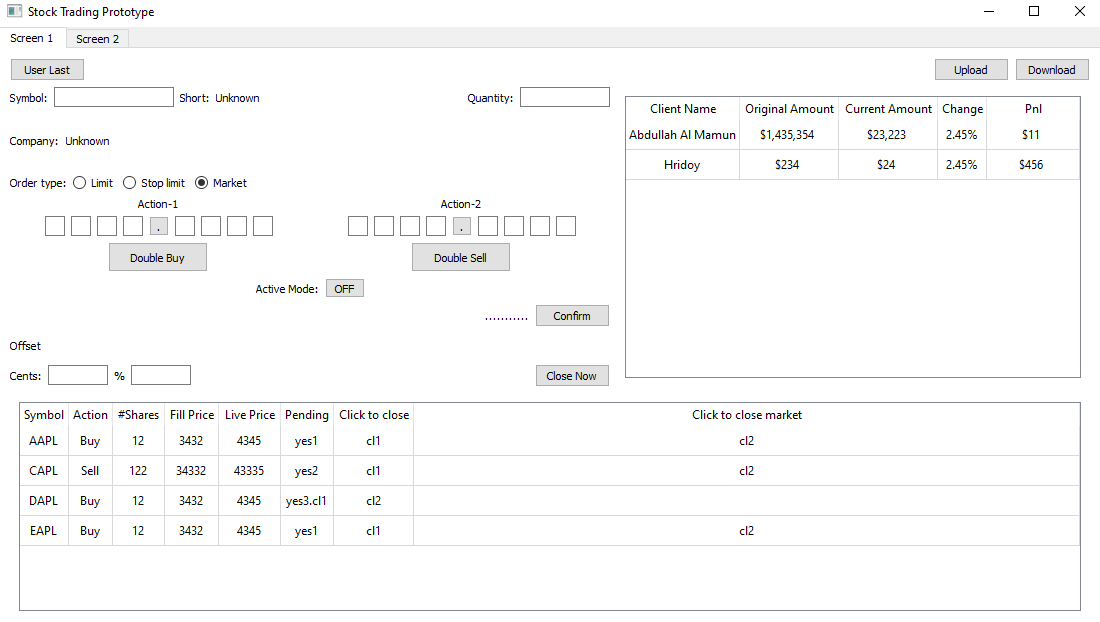

In [ ]:
#uploading criteria checks

def checking_eligibity_uploading(user):
    """
    :param: user : pd.DataFrame
    """
    if ('name' and'api_key' and 'email' and'phone') in user.columns:
        print('Eligible as all columns are there\n checking each shell')
        for i in range(0,len(user['name'])):
            if user['name'][i]=='' or user['api_key'][i]=='' or user['email'][i]==''or user['phone'][i]=='':
                print("shell is found empty")
                break
            else:
                print("all fields are filled\n")
    else:
        print('invalid')
checking_eligibity_uploading(user)

NameError: ignored

## Second Screen Handler Functions

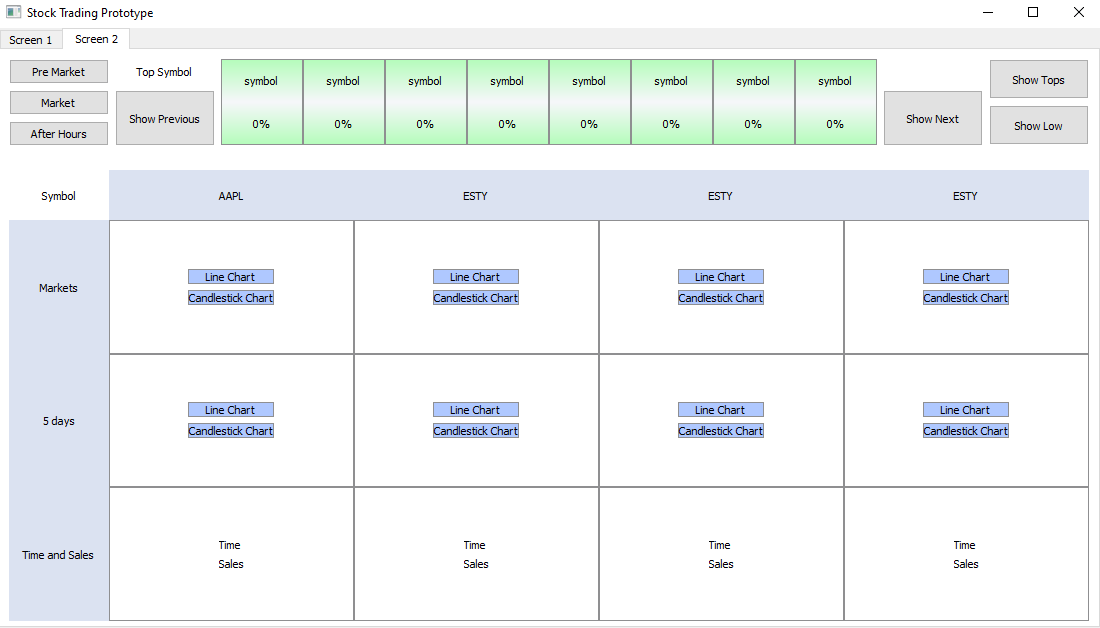

In [ ]:
#for second screen
from polygon import RESTClient
# Data______nanosecond
# Run infinite in sec screen 
def generate_barset_forever():
    dt=pd.read_csv("/content/drive/MyDrive/Office/Company_shortname.csv")
    for j in dt['symbol']:
      try:
        high = []
        low = []
        open = []
        close = []
        time = []
        volume = []
        df = pd.DataFrame()

        # RESTClient can be used as a context manager to facilitate closing the underlying http session
        # https://requests.readthedocs.io/en/master/user/advanced/#session-objects
        with RESTClient(polygon_auth_key) as client:
            resp = client.stocks_equities_aggregates(j,1,"minute","2021-05-08","2021-05-11")
            print(resp.ticker,resp.results)
            for i in range(0,len(resp.results)):
              high.append(resp.results[i]["h"])
              low.append(resp.results[i]["l"])
              open.append(resp.results[i]["o"])
              close.append(resp.results[i]["c"])
              time.append(resp.results[i]["t"])
              volume.append(resp.results[i]["v"])
            
            df["time"] = time
            df["high"] = high
            df["low"] = low
            df["open"] = open
            df["close"] = close
            df["volume"] = volume
            df.to_csv(f"/content/drive/MyDrive/Office/barset/barsetData{j}.csv",index=False)
      except Exception:
        pass

generate_barset_forever()

In [ ]:
def max3mover():
  df1=pd.read_csv("/content/drive/MyDrive/Office/Company_shortname.csv")
  avg_=[]
  ticker=[]
  for k in df1['symbol']:
    try:
      dx=pd.read_csv(f"/content/drive/MyDrive/Office/barset/barsetData{k}.csv")
      avg=sum(dx['volume'])/len(dx['volume'])
      avg_.append(avg)
      ticker.append(k)
    except:
      pass

  df2=pd.DataFrame()
  df2['ticker']=ticker
  df2['avgerage']=avg_

  #imply your formula here 
  avg_.sort(reverse=True)
  max1=df2.loc[df2['avgerage']==avg_[0]]
  max2=df2.loc[df2['avgerage']==avg_[1]]
  max3=df2.loc[df2['avgerage']==avg_[2]]
  return max1,max2,max3

mover=max3mover()
#mover is tupple





In [ ]:
mover[2]

,ticker,avgerage
2722,F,81049.158815


In [ ]:
max1

,ticker,avgerage
17,AAPL,118278.035026


In [ ]:
max2

,ticker,avgerage
1358,CERC,81111.717045


In [ ]:
max3

,ticker,avgerage
2722,F,81049.158815


In [ ]:
car

NameError: ignored

In [ ]:
car[0]

5

In [ ]:
for i in range(3):
  print(i)

0
1
2


In [ ]:
def read_time_from_nano_unix(nano_unix):
    print(nano_unix)
    from datetime import datetime
    dt = datetime.fromtimestamp(nano_unix // 1000000000)
    print(dt)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(nano_unix % 1000000000)).zfill(9)
    return s


print(read_time_from_nano_unix(1620996840000000000))

1620996840000000000
2021-05-14 12:54:00
2021-05-14 12:54:00.000000000
